# Few-Shot Learning

<!-- **Challenge:** [Omniglot](https://github.com/brendenlake/omniglot), the "transpose" of MNIST, with 1,623 character classes, each with 20 examples. Is it possible to build a few-shot classifier with a target of <35% error rate? -->

Humans exhibit a strong ability to acquire and recognize new patterns. In particular, we observe that when presented with stimuli, people seem to be able to understand new concepts quickly and then recognize variations on these concepts in future percepts. [Machine learning]() has been successfully used to achieve *state-of- the-art* performance in a variety of applications such as web search, spam detection, caption generation, and speech and image recognition. However, these algorithms often break down when forced to make predictions about data for which little supervised information is available. We desire to generalize to these unfamiliar categories without necessitating extensive retraining which may be either expensive or impossible due to limited data or in an online prediction setting, such as web retrieval.

One particularly interesting task is classification under the restriction that we may only observe a single example of each possible class before making a prediction about a test instance. This is called **[One-Shot Learning]()** and it is the primary focus in this notebook. This should be distinguished from **[Zero-shot Learning]()**, in which the model cannot look at any examples from the target classes.
**[Few-Shot Learning]()** on the other hand; is a special case of one-shot learning that tries to learn from *a very small set of training examples* rather than one –as in the one-shot learning case.


## Exploring the Dataset

**[Omniglot](https://github.com/brendenlake/omniglot)** is a collection of **1,623** hand drawn characters from **50 alphabets**. Each of the 1,623 characters is drawn online via *Amazon's Mechanical Turk* by 20 different people at resolution of `105x105`. It is sometimes reffered to as the **"Trasnpose of MNIST"**, since it has 1,623 types of character with only 20 examples each, in contrast to MNIST having thousands of examples for only 10 digits.

![Omniglot Dataset](images/omniglot.png)


### Structure of Omiglot Datasets

```sh
~ tree datasets/extracted -L 1
datasets/extracted
├── all_runs
├── images_background
└── images_evaluation

3 directories, 0 files
```

Omniglot has 3 different dataset serving different purposes.

- **`all_runs`**          - One-shot task.
- **`images_background`** - Training set.
- **`images_evaluation`** - Validation/ evaluation set.

> **Usage:** The **`images_background`** will be used for training *a Model* for *Few-shot Learning* and then validated on **`images_evaluation`**. While the **`all_runs`** will be used for *One-shot task*.

#### Training/Validation Dataset Structure

The training data contains 30 different *Alphabets* and the validation data contains 20 different alphabets *(that aren't in the training set)*, each containing *Characters* written differently.

```sh
$datasets/extracted$ ~ tree images_background -L 2
images_background
├── Alphabet_of_the_Magi
├── Anglo-Saxon_Futhorc
├── Arcadian
...
├── Sanskrit
├── Syriac_(Estrangelo)
├── Tagalog
└── Tifinagh

30 directories, 0 files
```

#### Alphabet Structure

A single *Alphabet* contains different *Characters*, each with 20 different *handwriting style*.

```sh
$datasets/extracted$ ~ tree images_background/Alphabet_of_the_Magi -L 2
images_background/Alphabet_of_the_Magi
├── character01
│   ├── 0709_01.png
│   ├── 0709_02.png
│   ├── 0709_03.png
│   ...
│   ├── 0709_18.png
│   ├── 0709_19.png
│   └── 0709_20.png
├── character02
│   ├── 0710_01.png
│   ├── 0710_02.png
│   ├── 0710_03.png
│   ...
│   ├── 0710_18.png
│   ├── 0710_19.png
│   └── 0710_20.png
...
├── character19
│   ├── 0727_01.png
│   ├── 0727_02.png
│   ├── 0727_03.png
│   ...
│   ├── 0727_18.png
│   ├── 0727_19.png
│   └── 0727_20.png
└── character20
    ├── 0728_01.png
    ├── 0728_02.png
    ├── 0728_03.png
    ...
    ├── 0728_18.png
    ├── 0728_19.png
    └── 0728_20.png

20 directories, 400 files
```

#### One-shot Task Structure

The **`all_runs`** folder consist of 20 runs each with a **training** and **test** folder.

```sh
$datasets/extracted$ ~ tree all_runs -L 2
├── run01
│   ├── class_labels.txt
│   ├── test
│   └── training
├── run02
│   ├── class_labels.txt
│   ├── test
│   └── training
...
├── run19
│   ├── class_labels.txt
│   ├── test
│   └── training
└── run20
    ├── class_labels.txt
    ├── test
    └── training
```

`class_labels.txt` consist of pairs of matching images in the `test` and `training` directories. The `test` and `training` directories contain 20 unique images each, where a single image in `test` matches another image in `training`.

The **One-shot** task is all about learning how to tell two images apart, i.e. Predict if two given images are of different or similar classes.

![One-shot Task](images/one-shot-task.png)


### Visualizing Dataset

Haven explored the data and looked into the file structures and what they mean, it's time to start looking at the actual images to see for ourselves what we're trying to do.

#### Training/Validation Dataset Visualization.

Since the training and validation dataset have similar file structure, it's safe to say it can be visulaized in a similar way. The file structures represent various *Alphabets* and side each Alphabet are different characters written differently.

> Visualization class has been nicely abstracted in the **`omniglot.Visualize`** class.

To use the `omniglot.Visualize` class, we need to make a few imports.

In [2]:
%matplotlib inline

# For OS operations.
import os

# # For Mathematical operations.
# import numpy as np

# # For High-level ML operations.
# from tensorflow import keras

# Helper package for omniglot's dataset & model.
import omniglot

# # Helper file for preparing input data.
# import utils

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The `omniglot.Visualize` has a relatively simple API. We provide the path to an Alphabet and then it plots a single letter (randommly) from 20 different characters of the Alphabet.

Firstly, extract the dataset if it isn't already extracted. This can be achieved by calling `omniglot.Dataset.extract(...)` method –which takes in a single required argument: `path` to a compressed file. It will be extracted to a default directory, but you can also provide `extract_dir`.

Already extracted to datasets/extracted/all_runs
Already extracted to datasets/extracted/images_background
Already extracted to datasets/extracted/images_evaluation


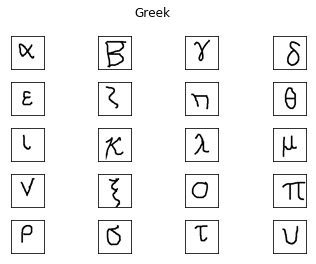

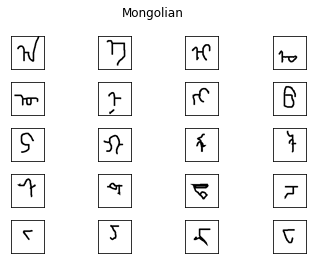

In [3]:
# Directory containing compressed files.
comp_dir = omniglot.compressed_dir

# Extract compressed dataset: `all_runs`, `images_background` & `images_evaluation`.
all_runs_dir = omniglot.Dataset.extract(os.path.join(comp_dir, 'all_runs.tar.gz'))
image_bg_dir = omniglot.Dataset.extract(os.path.join(comp_dir, 'images_background.tar.gz'))
image_ev_dir = omniglot.Dataset.extract(os.path.join(comp_dir, 'images_evaluation.tar.gz'))

# Visualize one random character from 20 different classes of Greek alphabet.
omniglot.Visualize.symbols(directory=os.path.join(image_bg_dir, 'Greek'))

# Visualize one random character from 20 different classes of Mongolian alphabet.
omniglot.Visualize.symbols(directory=os.path.join(image_ev_dir, 'Mongolian'))

#### One-shot Task Visualization

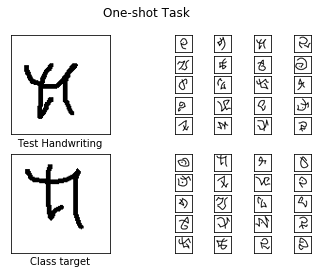

In [7]:
# Visualize the first run & select the 3rd image in the test directory
# and matching label in the train directory.
# (Simply put; emphaize the 3rd matching digits in "class_labels.txt").
omniglot.Visualize.runs(directory=os.path.join(all_runs_dir, 'run01'),
                        index=2, title='One-shot Task')

### N-way One-shot learning

Given a tiny labelled training set $S$, which has $ N $ examples, each vectors of the same dimension with a distinct label $y$.

$$ S = \{(x_i, y_i), ..., (x_N, y_N)\} $$

We're also given $\hat{x}$, the test example it has to classify. Since exactly one example in the training set has the right class, the aim is to correctly predict which $y \in S$ is the same as $\hat{x}$'s label, $\hat{y}$.

- Real world problems might not always have the constraint that exactly one image has the correct class.

- It's easy to generalize to k-shot learning by having there be $k$ examples for each $y_i$ rather than just one.

- When $N$ is higher, there are more possible classes that $\hat{x}$ can belong to, so it's harder to predict the correct one.

- Randomly guessing will average ${100\over n}\%$ accuracy.


Let's visualze some examples in the Omniglot dataset.

In [ ]:
# Path to compressed training & validation set.
train_path = os.path.join(omniglot.compressed_dir, 'images_background.tar.gz')
valid_path = os.path.join(omniglot.compressed_dir, 'images_evaluation.tar.gz')

# To avoid writing `omniglot.Dataset`...
Dataset = omniglot.Dataset

# Create training data instance.
train_data = Dataset(path=train_path, mode=Dataset.Mode.TRAIN)
print(f'\nTraining data: {train_data.shape}')
print(f'train_data = {train_data}')

# Create validation data instance.
valid_data = Dataset(path=valid_path, mode=Dataset.Mode.VALIDATE)
print(f'\nValidation data: {valid_data.shape}')
print(f'valid_data = {valid_data}')

## Exploring Models

### One-Shot Learning Baseline over Nearest Neighbor

<!-- TODO: Finish up docs. -->

The simplest way to perform classification is with **K-Nearest Neighbors**, but since there are only one example per class, we're only allowed 1 nearest neighbor lookup –which is really bad! K-Nearest Neigbors usually performs well with 5 neighbors or more *(but this also depends on dataset & it's sparsity)*.

Nearest Neighbor: This is just a way of measuring distance in a higher dimensional plane using distance metrics such as [Euclidean Distance]().

$$ \textrm{Euclidean Distance} = \sqrt{\sum_i^n{(q_i - p_i)^2}}$$

After calculating the Euclidean disance over `k` nearest neighbors. We then take the closest one:

$$ C(\hat{x}) = \underset{c \in S}{\operatorname{argmax}} \big\|\hat{x} - x_c\big\| $$

After calculating the Euclidean disance over `k` nearest neighbors. We then take the closest one:


In [ ]:
# Hyper-parameters.
epochs, batch_size = 5, 32
train_size, valid_size = len(train_data), len(valid_data)

In [ ]:
# Define the Siamese Network Model.
model = omniglot.SiameseNetwork()

# Compile using: Adam optimizer,
#                binary cross entropy loss function,
#                and monitor accuracy metrics.
model.compile(optimizer='rmsprop',
              loss=model.binary_crossentropy,
              metrics=['accuracy'])

try:
    # Get Training image pairs & targets.
    train_pairs, train_targets = train_data.get(train_size)
    valid_pairs, valid_targets = valid_data.get(valid_size)

    # Train the network.
    model.fit(train_pairs, train_targets, epochs=epochs, batch_size=batch_size,
              validation_data=(valid_pairs, valid_targets))

    # Save model weights.
    print(f'\n\n{"-" * 65}\nSaving model...')
    model.save_weights(filepath=model.model_weights,
                       overwrite=True, save_format=None)
    print(f'Saved model weights to "{model.model_weights}"!')
    print(f'{"-" * 65}\n')

except KeyboardInterrupt:
    # When training is unexpectedly stopped!
    print(f'\n\n{"-" * 65}')
    print('Training interrupted!', 'Saving model...', sep='\n')
    model.save_weights(filepath=model.model_weights,
                       overwrite=True, save_format=None)
    print(f'Saved model weights to "{model.model_weights}"!')
    print(f'{"-" * 65}\n')